# Ames Housing Code
------
- [Importing](#Import-Libraries,-Train-Data,-&-Test-Data) 
- [Data Cleaning](#Data-Cleaning)
- [Feature Engineering](#Feature-Engineering)
- [Modeling](#Modeling)

## Import Libraries, Train Data, & Test Data 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.pipeline import Pipeline


%matplotlib inline

In [2]:
df = pd.read_csv('./datasets/train.csv')
holdout = pd.read_csv('./datasets/test.csv')

## Data Cleaning


### 1. Converting Objects to Ordinal data

After referencing the data diciotnary if the inoformation within these columns seemed ranked I created an ordinal scale.

In [3]:
# creating odrinal colz
rating_dict ={'Ex':5,'Gd':4, 'TA':3,'Fa':2,'Po':1,'NA':0}
df['Kitchen Qual'] =df['Kitchen Qual'].replace(rating_dict)
df['Heating QC'] =df['Heating QC'].replace(rating_dict)
df['Bsmt Qual'] =df['Bsmt Qual'].replace(rating_dict) 
# Electrical
elec_dict={'SBrkr':4,'FuseA':3,'FuseF':2,'FuseP':1,'Mix':0 }
df['Electrical'] =df['Electrical'].replace(elec_dict)
# Paved Drive
pve_key = {'Y': 2,'P': 1,'N': 0 }
df['Paved Drive'] =df['Paved Drive'].replace(pve_key)
# Garage Finish
garage_dict = {'Fin':3, 'RFn':2,  'Unf':1, 'NA':0  }
df['Garage Finish'] =df['Garage Finish'].replace(garage_dict)
# Bsmt FinType1
basement_dict ={'GLQ' :6,'ALQ' :5,'BLQ' :4,'Rec' :3,'LwQ' :2,'Unf':1,'NA':0 }
df['BsmtFin Type 1'] =df['BsmtFin Type 1'].replace(basement_dict)
# Bsmt Exposure
base_exp = {'Gd' :4,'Av' :3,'Mn' :2,'No' :1,'NA':0}
df['Bsmt Exposure'] =df['Bsmt Exposure'].replace(base_exp)

### 2. Dummy Columns

Created dummy columns for categorical data and dropped the first column.

In [4]:
#dummies 
['Garage Type','Foundation','Exterior 1st','House Style', 'Neighborhood', 'MS Zoning']
df = pd.concat([df, pd.get_dummies(df['Garage Type'], prefix ='garage_type_', drop_first= True)],axis =1)
df = pd.concat([df, pd.get_dummies(df['Foundation'], prefix ='foundation_',drop_first= True)], axis =1)
df = pd.concat([df, pd.get_dummies(df['Exterior 1st'], prefix ='exterior_',drop_first= True)], axis =1)
df = pd.concat([df, pd.get_dummies(df['House Style'], prefix ='house_style_',drop_first= True)], axis =1)
df = pd.concat([df, pd.get_dummies(df['Neighborhood'], prefix ='neighborhood_',drop_first= True)], axis =1)
df = pd.concat([df, pd.get_dummies(df['MS Zoning'], prefix ='zoning_',drop_first= True)], axis =1)
#drop oringinals
df.drop(columns =['Garage Type','Foundation','Exterior 1st','House Style', 'Neighborhood', 'MS Zoning'], inplace =True)

### 3. Dropping Columns
Dropped columns that had too many nulls or had a distribution that was largely skewed

In [5]:
df['Bsmt Qual'].value_counts()

3    887
4    864
5    184
2     60
1      1
Name: Bsmt Qual, dtype: int64

In [6]:
# dropped colls for nulls and biased distribution
df.drop(columns = ['Alley','Pool QC', 'Fireplace Qu', 'Fence', 'Misc Feature','Garage Area', 'Garage Cars', 'Total Bsmt SF', 'Garage Yr Blt', 'Mas Vnr Area', 'BsmtFin SF 1', 'Lot Frontage'], inplace= True)
df.drop(columns = ['Mas Vnr Type', 'Exterior 2nd', 'BsmtFin Type 2', 'Condition 2','Lot Config'], inplace = True)
df.drop(columns = ['Sale Type' ,'Heating', 'Roof Matl', 'Roof Style', 'Bldg Type', 'Condition 1', 'Lot Shape','Central Air', 'Street'], inplace =True)
df.drop(columns = ['Garage Qual','Garage Cond', 'Bsmt Cond', 'Exter Cond' , 'Exter Qual', 'Utilities', 'Land Slope', 'Land Contour', 'Functional'], inplace=True)

## Feature Engineering
After applying correlation mask, used multiple interaction techniques to create three columns of interaction

In [7]:
#created a new feature that interacts Year Built and Year Remod/Add
df['year_interaction']= df['Year Built']* df['Year Remod/Add']
#created a new feature that interacts two types of porches
df['porch_interaction']= df['Open Porch SF'] * df['Wood Deck SF']
#created a new feature that interacts fireplaces and rooms above ground
df['fire_rooms']= df['Fireplaces'] * df['TotRms AbvGrd']
#drop the originals due to coliniarity
df.drop(columns =['TotRms AbvGrd', 'Year Built', 'Year Remod/Add', 'Fireplaces', 'TotRms AbvGrd', 'Bsmt Full Bath', 'Bsmt Unf SF'], inplace =True)

In [8]:
# apply mask of 1 < x > .3 of correlation
corr_results = df.corr()[['SalePrice']].sort_values('SalePrice', ascending=False)
corr_filter = corr_results[(abs(corr_results['SalePrice']) > .3)&(abs(corr_results['SalePrice']) < 1)]
corr_filter

,SalePrice
Overall Qual,0.800207
Gr Liv Area,0.697038
year_interaction,0.622283
1st Flr SF,0.618486
fire_rooms,0.542059
Full Bath,0.537969
foundation__PConc,0.529047
neighborhood__NridgHt,0.448647
garage_type__Attchd,0.357879
porch_interaction,0.352388


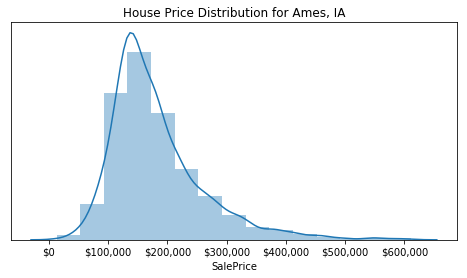

In [9]:
# presentation dist plot
plt.figure(figsize=(8,4))
sns.distplot(df['SalePrice'],bins =15,)
plt.yticks([])
plt.xticks(ticks = [0,100000,200000,300000,400000,500000,600000],
           labels =['$0', '$100,000', '$200,000', '$300,000', '$400,000', '$500,000', '$600,000'])
plt.title('House Price Distribution for Ames, IA')
plt.savefig('house.png');

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


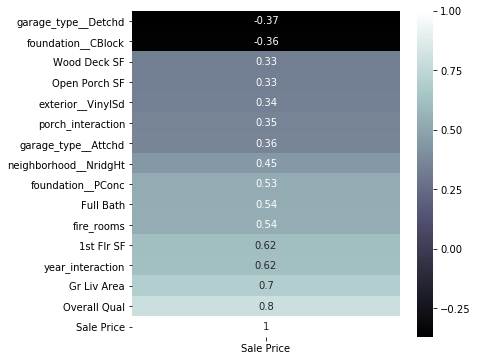

In [10]:
# presentation heatmap
presentation_df = df[corr_filter.index]
presentation_df['Sale Price'] = df['SalePrice']
plt.figure(figsize=(6, 6))
sns.heatmap(presentation_df.corr()[['Sale Price']].sort_values('Sale Price'), annot=True, cmap='bone');

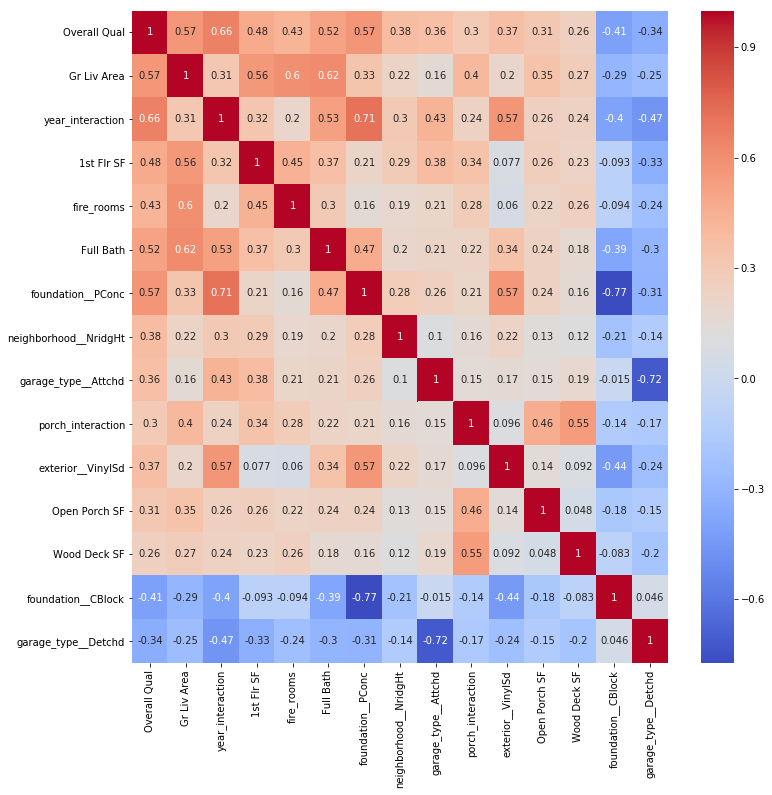

In [11]:
# check for colineiarity
plt.figure(figsize=(12,12))
sns.heatmap(df[corr_filter.index].corr(), annot=True, cmap = 'coolwarm');

EDA & Feature Engineering applied to Holdout

In [12]:
holdout.drop(columns = ['Alley','Pool QC', 'Fireplace Qu', 'Fence', 'Misc Feature','Garage Area', 'Garage Cars', 'Total Bsmt SF', 'Garage Yr Blt', 'Mas Vnr Area', 'BsmtFin SF 1', 'Lot Frontage'], inplace= True)
holdout.drop(columns = ['Mas Vnr Type', 'Exterior 2nd', 'BsmtFin Type 2', 'Condition 2','Lot Config'], inplace = True)
holdout.drop(columns = ['Sale Type' ,'Heating', 'Roof Matl', 'Roof Style', 'Bldg Type', 'Condition 1', 'Lot Shape','Central Air', 'Street'], inplace =True)
holdout.drop(columns = ['Garage Qual','Garage Cond', 'Bsmt Cond', 'Exter Cond' , 'Exter Qual', 'Utilities', 'Land Slope', 'Land Contour', 'Functional'], inplace=True)
holdout = pd.concat([holdout, pd.get_dummies(holdout['Garage Type'], prefix ='garage_type_', drop_first= True)],axis =1)
holdout = pd.concat([holdout, pd.get_dummies(holdout['Foundation'], prefix ='foundation_',drop_first= True)], axis =1)
holdout = pd.concat([holdout, pd.get_dummies(holdout['Exterior 1st'], prefix ='exterior_',drop_first= True)], axis =1)
holdout = pd.concat([holdout, pd.get_dummies(holdout['House Style'], prefix ='house_style_',drop_first= True)], axis =1)
holdout = pd.concat([holdout, pd.get_dummies(holdout['Neighborhood'], prefix ='neighborhood_',drop_first= True)], axis =1)
holdout = pd.concat([holdout, pd.get_dummies(holdout['MS Zoning'], prefix ='zoning_',drop_first= True)], axis =1)
holdout.drop(columns =['Garage Type','Foundation','Exterior 1st','House Style', 'Neighborhood', 'MS Zoning'], inplace =True)
rating_dict ={'Ex':5,'Gd':4, 'TA':3,'Fa':2,'Po':1,'NA':0}
holdout['Kitchen Qual'] =holdout['Kitchen Qual'].replace(rating_dict)
holdout['Heating QC'] =holdout['Heating QC'].replace(rating_dict)
holdout['Bsmt Qual'] =holdout['Bsmt Qual'].replace(rating_dict) 
elec_dict={'SBrkr':4,'FuseA':3,'FuseF':2,'FuseP':1,'Mix':0 }
holdout['Electrical'] =holdout['Electrical'].replace(elec_dict)
pve_key = {'Y': 2,'P': 1,'N': 0 }
holdout['Paved Drive'] =holdout['Paved Drive'].replace(pve_key)
garage_dict = {'Fin':3, 'RFn':2,  'Unf':1, 'NA':0  }
holdout['Garage Finish'] =holdout['Garage Finish'].replace(garage_dict)
basement_dict ={'GLQ' :6,'ALQ' :5,'BLQ' :4,'Rec' :3,'LwQ' :2,'Unf':1,'NA':0 }
holdout['BsmtFin Type 1'] =holdout['BsmtFin Type 1'].replace(basement_dict)
base_exp = {'Gd' :4,'Av' :3,'Mn' :2,'No' :1,'NA':0}
holdout['Bsmt Exposure'] =holdout['Bsmt Exposure'].replace(base_exp)
holdout['year_interaction']= holdout['Year Built']* holdout['Year Remod/Add']
holdout['porch_interaction']= holdout['Open Porch SF'] * holdout['Wood Deck SF']
holdout['fire_rooms']= holdout['Fireplaces'] * holdout['TotRms AbvGrd']
holdout.drop(columns = ['TotRms AbvGrd', 'Year Built', 'Year Remod/Add', 'Fireplaces', 'TotRms AbvGrd', 'Bsmt Full Bath', 'Bsmt Unf SF'], inplace = True)

## Modeling 
Creating a Pipeline as a starting point to compare results and using GridSearch to optimize model performance

In [15]:
features = corr_filter.index
X = df[features]
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state =25)
pipe.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('sscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [13]:
pipe = Pipeline([
                ('poly', PolynomialFeatures()),
                ('sscaler', StandardScaler()),
                ('lasso', Lasso())
                ])

In [14]:
#chose variables to maximize and models to use
params = {'poly__degree': [4],
         'lasso__alpha': [196,198,200,202] }
grid = GridSearchCV(pipe, param_grid = params, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
grid.best_estimator_

In [ ]:
best_nums = grid.best_estimator_
best_nums.fit(X_train, y_train)

In [ ]:
best_nums.score(X_train, y_train)

In [ ]:
best_nums.score(X_test, y_test)

In [16]:
#using pipeline for workflow
pipe = Pipeline([
                ('poly', PolynomialFeatures()),
                ('sscaler', StandardScaler()),
                ('ridge', Ridge())
                ])

In [17]:
params = {'poly__degree': [2],
         'ridge__alpha': [494,496,498] }
grid = GridSearchCV(pipe, param_grid = params, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('sscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'poly__degree': [2], 'ridge__alpha': [494, 496, 498]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [18]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('sscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=498, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [ ]:
# strangest (overall qual * 1st Fl sf) // Overal Qual //Qual ** live area // GR liv & Bath

In [19]:
#getting the coefs and their coresponding column index
for feature, coef in zip(pipe.named_steps['ridge'].coef_, pipe.named_steps['poly'].get_feature_names()):
    print(feature, coef)

AttributeError: 'Ridge' object has no attribute 'coef_'

In [ ]:
#that above is a dictionary, and use
#key for estimator
grid.named_steps['ridge'].coef_

In [20]:
best_nums = grid.best_estimator_
best_nums.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('sscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=498, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [21]:
y_pred = best_nums.predict(X_test)

In [22]:
rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
r2 = round(best_nums.score(X_train, y_train),2)
tr2 = round(best_nums.score(X_test, y_test),2)
med = round(median_absolute_error(y_test, y_pred))

In [23]:
project_dict = {'RMSE': rmse,
               'Train R2': r2,
               'Test R2': tr2,
               'MedAE': med}
df2 =pd.DataFrame(project_dict, index =[0])
df2.T

,0
RMSE,31598.71
Train R2,0.85
Test R2,0.85
MedAE,14827.00


In [24]:
best_nums.score(X_test, y_test)

0.8503950865634944

In [26]:
# load and test data at kaggle
y_pred = best_nums.predict(holdout[features])
sub = holdout[["Id"]]
sub['SalePrice'] = y_pred
sub.to_csv('./datasets/finished_model_.csv', index = False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
